In [2]:
#A bit of feedback:

#Hi, first of all I thouroughly enjoyed the exercises and I think they are a good test of a candidates skill-set. I feel like I learned a good amount
#throughout too!!
#There were some times that I was confused with what was being asked for a particular question. For example, I was slightly
#unsure about the wording of question 5, as to whether it was asking for the median of the daily production for each inverter, or
#..the median of the daily productionS across the different inverters. I have generally just assumed which I feel to be more likely when
#it comes to these, since I thought this may be part of what you are assessing. However, just for reference, in a real working environment
#... I would of course ask to clarify details such as these, and just wanted to make that clear. 

#Also note that I have commented out a few csv exports which I used to view the data in Excel, which do not need to be run for the program to work.

###########1.1###############

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib widget
%matplotlib inline

gen1 = pd.read_csv(r'C:\Users\Alex\OneDrive\Documents\plant1gen.csv') #This file is just the dataset provided (plant1gen as attached)

In [3]:
gen1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15/05/2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15/05/2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15/05/2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15/05/2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15/05/2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


<AxesSubplot:>

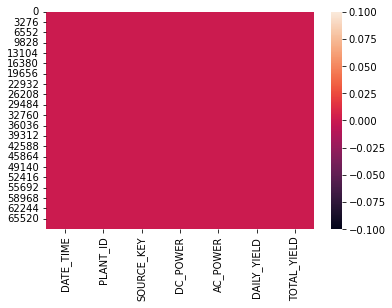

In [4]:
#Just going to plot a visualisation of the null values to get a feel for the data. 

sns.heatmap(gen1.isnull())

#Okay so it's not the percentage of missing values, I think it is the absence of the summed daily_yield
#I am assuming that the source key refers to the individual inverter. Let's count the occurances to be sure

#gen1['SOURCE_KEY'].value_counts()

#These clearly indicate the inverter codes. We see the bvBO...ry has the most instances across the dataframe

#Looking at the dataset, the daily yields increase, and do not fluctuate as would in instantaneous value
#Therefore, the daily yield is a daily summative/cumalative quantity.
#It increases throughout the day, until it goes to zero, although I am unsure of what causes the drop
#I have seen yields go to zero while still receiving power, perhaps they go to zero after some time of no power?

#Need to find the conditions of the daily final daily_yield in order to sum and thus compare to the total yield. 

In [5]:
#Ultimately we want to find the percentage of 'missing data' in the total yield. However I must ascertain what the missing data
#actually refers to. For now I am testing whether it is when the daily yield which has not been added to the total yield
#Then it must be escertained what is really meant by a percentage of missing data. Is this referring to the percentage of 
#instances which have not been logged out of the total number of instances, or is it referring to the percentage of missing total
#yield? 

percent_missing = gen1.isnull().sum() * 100 / len(gen1)
percent_missing

#There are no missing values 

DATE_TIME      0.0
PLANT_ID       0.0
SOURCE_KEY     0.0
DC_POWER       0.0
AC_POWER       0.0
DAILY_YIELD    0.0
TOTAL_YIELD    0.0
dtype: float64

In [6]:
#I have just realised that given this is a time series, and the number of value counts differ for each inverter, perhaps this is what
#the missing data is referring to.

gen1['SOURCE_KEY'].value_counts()

bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64

In [7]:
#Upon inspection of YxYtjZvoooNbGkE, it can be observed that some time-instances of the inverter are skipped.
#However, it must be ascertained what the condition of this skipping is, i.e., when does the skipping occur, and does it skip
#important instances, or just instances that don't contribute to the total yield? It says in Task 1.2, that it can be assumed that the
#inverters were not in operation during the missing value periods. For now, let's find the percentage of missing instances, rather
#than yield, for each inverter. 


In [8]:
counts1 = gen1[['SOURCE_KEY','TOTAL_YIELD']]
counts1

#df = gen1.value_counts().rename_axis('unique_values').reset_index(name='counts')
#print (df)

,SOURCE_KEY,TOTAL_YIELD
0,1BY6WEcLGh8j5v7,6259559.0
1,1IF53ai7Xc0U56Y,6183645.0
2,3PZuoBAID5Wc2HD,6987759.0
3,7JYdWkrLSPkdwr4,7602960.0
4,McdE0feGgRqW7Ca,7158964.0
...,...,...
68773,uHbuxQJl8lW7ozc,7287002.0
68774,wCURE6d3bPkepu2,7028601.0
68775,z9Y9gH1T5YWrNuG,7251204.0
68776,zBIq5rxdHJRwDNY,6583369.0


In [9]:
value_counts = gen1['SOURCE_KEY'].value_counts()
df_val_counts = pd.DataFrame(value_counts)

In [10]:
df_val_counts

,SOURCE_KEY
bvBOhCH3iADSZry,3155
1BY6WEcLGh8j5v7,3154
7JYdWkrLSPkdwr4,3133
VHMLBKoKgIrUVDU,3133
ZnxXDlPa8U1GXgE,3130
ih0vzX44oOqAx2f,3130
z9Y9gH1T5YWrNuG,3126
wCURE6d3bPkepu2,3126
uHbuxQJl8lW7ozc,3125
pkci93gMrogZuBj,3125


In [11]:
df_val_counts['Percentage Missing (%)'] = 100-((df_val_counts['SOURCE_KEY'] /3155)*100) 


#####NOTE: I changed my answer to this later on, as marked#########

In [12]:
df_val_counts

,SOURCE_KEY,Percentage Missing (%)
bvBOhCH3iADSZry,3155,0.000000
1BY6WEcLGh8j5v7,3154,0.031696
7JYdWkrLSPkdwr4,3133,0.697306
VHMLBKoKgIrUVDU,3133,0.697306
ZnxXDlPa8U1GXgE,3130,0.792393
ih0vzX44oOqAx2f,3130,0.792393
z9Y9gH1T5YWrNuG,3126,0.919176
wCURE6d3bPkepu2,3126,0.919176
uHbuxQJl8lW7ozc,3125,0.950872
pkci93gMrogZuBj,3125,0.950872


In [13]:
#Assuming the inverters were not in operation during the absent periods, the fields: DC_POWER, AC_POWER,SOURCE_KEY,...
#...PLANT_ID would be easy to determine. DC/AC would be zero, the SOURCE_KEY is that of the inverter in question, plant_id
#is constant across the dataframe. However, it is questionable as to whether the daily_yield would be zero. It simply states that 
#the inverters were 'not in operation'. This could potentially occur to say some technical fault during the day at any time - and the
#dc/ac would be zero.

#We could just check when the missing instances seem to occur. The missing instances will obviously be told by time-skips
#We want to essentially tally the number of instances where the following condition is met:
# there is a 'time-skip' and the daily yield is zero. If this makes up all the missing instances, namely

Total = df_val_counts['SOURCE_KEY'].sum()

Number_missing_instances = 3155*(len(df_val_counts.index))-Total
Number_missing_instances

#Then we know that all the time-skips occur when the daily yield value is zero. 

632

In [14]:
#We can compare our time series to a dummy time series

In [15]:
#An attempt to find the locations of the missing dates 

date_range = pd.date_range('2020-05-15 00:00', '2020-06-17 23:45', freq='15Min')
df8 = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
df8.index = date_range 

In [16]:
df8

,0
2020-05-15 00:00:00,18
2020-05-15 00:15:00,2
2020-05-15 00:30:00,1
2020-05-15 00:45:00,16
2020-05-15 01:00:00,6
...,...
2020-06-17 22:45:00,13
2020-06-17 23:00:00,15
2020-06-17 23:15:00,12
2020-06-17 23:30:00,7


In [17]:
#An attempt to find the locations of the missing dates 

missing_dates = df8.index[~df8.index.isin(gen1.index)]
missing_dates

DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:15:00',
               '2020-05-15 00:30:00', '2020-05-15 00:45:00',
               '2020-05-15 01:00:00', '2020-05-15 01:15:00',
               '2020-05-15 01:30:00', '2020-05-15 01:45:00',
               '2020-05-15 02:00:00', '2020-05-15 02:15:00',
               ...
               '2020-06-17 21:30:00', '2020-06-17 21:45:00',
               '2020-06-17 22:00:00', '2020-06-17 22:15:00',
               '2020-06-17 22:30:00', '2020-06-17 22:45:00',
               '2020-06-17 23:00:00', '2020-06-17 23:15:00',
               '2020-06-17 23:30:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', length=3264, freq='15T')

In [18]:
#This is looking potentially quite tricky. I am not sure if this is really necessary for the analysis. 
#In part 3, we are looking at the production of inverters on a 15min basis. One may think that this
#refers to simply the difference between the total_yield at row x and row x-1 throughout the dataset, in order to obtain the 
#production within that 15 minute interval. However, is an average of all those 15 minute values for the particular inverter, or 
#is it simply the production plotted as a time series. I would imagine the former, given the latter would be very erratic and difficult to follow
#So if we are looking at the difference between the inverter total_yield values, then do we even need to identify the specific 
#locations where the total yield is missing, can we just not add a few randomly chosen values, given we are looking at the difference?

#We then have to calculate the daily production. It asks for the median for this daily production of all inverters, I'm not certain 
#if this is referring to finding the median production for each individual inverter, and then comparing all of those medians, or 
#comparing the median of the 'daily production' values for all inverters which themselves are an average daily production





In [19]:
value_counts2 = gen1['DATE_TIME'].value_counts()
df_val_counts2 = pd.DataFrame(value_counts2)

df_val_counts2

,DATE_TIME
01/06/2020 12:45,22
07/06/2020 00:00,22
07/06/2020 00:30,22
07/06/2020 00:45,22
07/06/2020 01:00,22
...,...
06/06/2020 18:15,10
04/06/2020 18:45,10
29/05/2020 19:00,10
25/05/2020 05:30,4


In [20]:
#df_val_counts2.to_csv('out.csv')

In [21]:
gen1

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15/05/2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15/05/2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15/05/2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15/05/2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15/05/2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17/06/2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17/06/2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17/06/2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17/06/2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


In [22]:
gen1[['Date','Time']] = gen1.DATE_TIME.str.split(" ",expand=True,)
gen1

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Date,Time
0,15/05/2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,15/05/2020,00:00
1,15/05/2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,15/05/2020,00:00
2,15/05/2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,15/05/2020,00:00
3,15/05/2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,15/05/2020,00:00
4,15/05/2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,15/05/2020,00:00
...,...,...,...,...,...,...,...,...,...
68773,17/06/2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,17/06/2020,23:45
68774,17/06/2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,17/06/2020,23:45
68775,17/06/2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,17/06/2020,23:45
68776,17/06/2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,17/06/2020,23:45


In [23]:
gen1.sort_values(by='SOURCE_KEY', ascending=True)
#gen1.sort_values(by='Date', ascending=True)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Date,Time
0,15/05/2020 00:00,4135001,1BY6WEcLGh8j5v7,0.000000,0.000000,0.000000,6259559.000,15/05/2020,00:00
24988,27/05/2020 18:30,4135001,1BY6WEcLGh8j5v7,0.000000,0.000000,6164.000000,6349833.000,27/05/2020,18:30
24978,27/05/2020 18:15,4135001,1BY6WEcLGh8j5v7,125.500000,12.100000,6162.750000,6349831.750,27/05/2020,18:15
24956,27/05/2020 18:00,4135001,1BY6WEcLGh8j5v7,266.571429,25.728571,6157.857143,6349826.857,27/05/2020,18:00
24934,27/05/2020 17:45,4135001,1BY6WEcLGh8j5v7,552.750000,53.487500,6148.125000,6349817.125,27/05/2020,17:45
...,...,...,...,...,...,...,...,...,...
30675,30/05/2020 20:00,4135001,zVJPv84UY57bAof,0.000000,0.000000,7290.000000,7235977.000,30/05/2020,20:00
49989,09/06/2020 01:45,4135001,zVJPv84UY57bAof,0.000000,0.000000,0.000000,7302167.000,09/06/2020,01:45
64729,16/06/2020 01:15,4135001,zVJPv84UY57bAof,0.000000,0.000000,0.000000,7351100.000,16/06/2020,01:15
21783,26/05/2020 05:15,4135001,zVJPv84UY57bAof,0.000000,0.000000,0.000000,7197609.000,26/05/2020,05:15


In [24]:
gen1b = gen1.sort_values(['SOURCE_KEY', 'TOTAL_YIELD'], ascending=[True, True])
gen1b

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Date,Time
0,15/05/2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:00
21,15/05/2020 00:15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:15
42,15/05/2020 00:30,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:30
63,15/05/2020 00:45,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:45
84,15/05/2020 01:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,01:00
...,...,...,...,...,...,...,...,...,...
68689,17/06/2020 22:45,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,22:45
68711,17/06/2020 23:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,23:00
68733,17/06/2020 23:15,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,23:15
68755,17/06/2020 23:30,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,23:30


In [25]:
def marker(time):
    if time.endswith('15'):
        return 15
    elif time.endswith('30'):
        return 30
    elif time.endswith('45'):
        return 45
    else:
        return 0
        

In [26]:
gen1b['marker'] = [marker(x) for x in gen1b['Time']]

In [27]:
gen1b

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Date,Time,marker
0,15/05/2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:00,0
21,15/05/2020 00:15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:15,15
42,15/05/2020 00:30,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:30,30
63,15/05/2020 00:45,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,00:45,45
84,15/05/2020 01:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020,01:00,0
...,...,...,...,...,...,...,...,...,...,...
68689,17/06/2020 22:45,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,22:45,45
68711,17/06/2020 23:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,23:00,0
68733,17/06/2020 23:15,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,23:15,15
68755,17/06/2020 23:30,4135001,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020,23:30,30


In [28]:
refined_df = gen1b[['SOURCE_KEY','TOTAL_YIELD', 'marker']]
refined_df

#Was thinking of duplicating rows based on the difference between the marker on different rows in order to find 'skipped instances' and remedy them
#However I am struggling to find a way to do this.



,SOURCE_KEY,TOTAL_YIELD,marker
0,1BY6WEcLGh8j5v7,6259559.0,0
21,1BY6WEcLGh8j5v7,6259559.0,15
42,1BY6WEcLGh8j5v7,6259559.0,30
63,1BY6WEcLGh8j5v7,6259559.0,45
84,1BY6WEcLGh8j5v7,6259559.0,0
...,...,...,...
68689,zVJPv84UY57bAof,7363272.0,45
68711,zVJPv84UY57bAof,7363272.0,0
68733,zVJPv84UY57bAof,7363272.0,15
68755,zVJPv84UY57bAof,7363272.0,30


In [29]:
#Potentially easier way that may work with the analysis of the task

#1. We could assume that we can just add a number of duplicate rows to the particular inverter, where the number of duplicate rows is equivalent to the number of missing values
#2. However, the question is whether this would work with the analysis required in later parts of section 1.
#3.Assuming 3 is asking for an average of the inverter production for each inverter every 15 mins then you obviously need extra rows for the average production where production 
#...is (total-(total on previous row)) in order for the average to work. Otherwise, the production average will be too high, since it is not taking into account the times when it is not in operation. 
#...It arguably is the average we are looking for, since the other graph of immediate 15 min values across the whole series for every single inverter would look like a mess.

#4.So we just duplicate the number of rows for the amount of times there are absenses for the particular inverter.
#5.Then, for question 5, we are to 'calculate the daily production' and 'calculate the median for this daily production of all the inverters. I think this is asking for one stat, the median production 
#...across the singular daily production values for each inverter. However, this could also potentially refer to finding the median production across a daily production average for a particular inverter, 
#...then comparing these different median daily production values, .i.e., a median is obtained for each inverter and these medians are compared.
#However, based on the wording of the question, and the degree of rigor required otherwise, I would assume it is the first.

In [30]:
#So, let's add in additional rows that technically 'mess-up' the time series, which shall have repeated values, however it should
#...not mess up the calculations further along, 

#I have found a way to do this in a somewhat easy way. Courtesy of this:" https://stackoverflow.com/questions/49074021/repeat-rows-in-data-frame-n-times "

#Hence we need to alter the dataframe accordingly, where we assign the number of rows less than the full range of 3155

##########################1.1########################

#IN FACT, I have just realised that I have made a mistake, by looking at the evolution of the time series in 15 minute chunks through Python
#as below, we see that all of the inverters are missing rows...

#...and it was quite a poor assumption to assume that the highest inverter would fall on the maximum...

df8

,0
2020-05-15 00:00:00,18
2020-05-15 00:15:00,2
2020-05-15 00:30:00,1
2020-05-15 00:45:00,16
2020-05-15 01:00:00,6
...,...
2020-06-17 22:45:00,13
2020-06-17 23:00:00,15
2020-06-17 23:15:00,12
2020-06-17 23:30:00,7


In [31]:
#Just double checking this in Excel

#df8.to_csv('df8.csv')

In [32]:
#Hence there are 3264 total rows required for the time-series to be complete. Now repeating the previous calculation of percentages.

df_val_counts['Percentage Missing (%)'] = 100-((df_val_counts['SOURCE_KEY'] /3264)*100) 

In [33]:
df_val_counts

,SOURCE_KEY,Percentage Missing (%)
bvBOhCH3iADSZry,3155,3.339461
1BY6WEcLGh8j5v7,3154,3.370098
7JYdWkrLSPkdwr4,3133,4.013480
VHMLBKoKgIrUVDU,3133,4.013480
ZnxXDlPa8U1GXgE,3130,4.105392
ih0vzX44oOqAx2f,3130,4.105392
z9Y9gH1T5YWrNuG,3126,4.227941
wCURE6d3bPkepu2,3126,4.227941
uHbuxQJl8lW7ozc,3125,4.258578
pkci93gMrogZuBj,3125,4.258578


In [34]:
#In numbers this is the following 

#########1.2 continued###############


df_val_counts['Quantity Missing'] = 3264-df_val_counts['SOURCE_KEY']
df_val_counts

,SOURCE_KEY,Percentage Missing (%),Quantity Missing
bvBOhCH3iADSZry,3155,3.339461,109
1BY6WEcLGh8j5v7,3154,3.370098,110
7JYdWkrLSPkdwr4,3133,4.013480,131
VHMLBKoKgIrUVDU,3133,4.013480,131
ZnxXDlPa8U1GXgE,3130,4.105392,134
ih0vzX44oOqAx2f,3130,4.105392,134
z9Y9gH1T5YWrNuG,3126,4.227941,138
wCURE6d3bPkepu2,3126,4.227941,138
uHbuxQJl8lW7ozc,3125,4.258578,139
pkci93gMrogZuBj,3125,4.258578,139


In [35]:
#Hence these are the quantities that we would like to duplciate rows arbitarily.

#Back to this
#https://stackoverflow.com/questions/49074021/repeat-rows-in-data-frame-n-times 

#However, I have just realised that this uses repeat, and thus potentially ALL elements with the source key could be repeated N times
#Really, we want N additional rows, or a singular row to be repeated N+1 times, depending exactly on what repeated means here

#What we could do is instead of using the source key as out id of repitition, we could use a random marker than we assign to a random
#row for each inverter, which can be done on hastily on Excel, then the remaining values will be null. Then we use those markers as the 
#id for repitition. 

#df_val_counts.to_csv('df_val_counts.csv')

In [36]:
gen1v2 = pd.read_csv(r'C:\Users\Alex\OneDrive\Documents\plant1genv2.csv')

#The file loaded in here is plantgen1v2 attached on the email, if you would like to see the code in action

In [37]:
gen1v2

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,PLANT_ID,REP_MARKER
0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:00,4135001,NaN
1,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:15,4135001,NaN
2,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:30,4135001,NaN
3,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:45,4135001,NaN
4,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 01:00,4135001,NaN
...,...,...,...,...,...,...,...,...
68773,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 22:45,4135001,NaN
68774,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:00,4135001,NaN
68775,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:15,4135001,NaN
68776,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:30,4135001,NaN


In [38]:
#Markers are in place. Although we may need a seperate marker for the NaN to specify that they dont need to be repeated? Let's try without first

#gen1v2.loc[gen1v2.index.repeat(gen1v2.REP_MARKER)]
#Maybe issues with the NaN 
gen1v2['REP_MARKER'] = gen1v2['REP_MARKER'].fillna(0)

In [39]:
repped = gen1v2.loc[gen1v2.index.repeat(gen1v2.REP_MARKER)]
#gen1v2

In [40]:
#Okay we are getting 3030 rows, which isthe sum of the 'Quantity Missing' values. 

#Okay so its just creating a new dataframe without the 0 values...

In [41]:
#repped.to_csv('repped.csv')
#gen1v2.to_csv('reppedfull.csv')

In [42]:
#So the repetitions are working, we are just getting a new df, and so all the zeros must be converted into 1's 

gen1v2['REP_MARKER'] = gen1v2['REP_MARKER'].replace(0.0,1)
repped2 = gen1v2.loc[gen1v2.index.repeat(gen1v2.REP_MARKER)]

In [43]:
gen1v2

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,PLANT_ID,REP_MARKER
0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:00,4135001,1.0
1,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:15,4135001,1.0
2,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:30,4135001,1.0
3,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:45,4135001,1.0
4,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 01:00,4135001,1.0
...,...,...,...,...,...,...,...,...
68773,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 22:45,4135001,1.0
68774,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:00,4135001,1.0
68775,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:15,4135001,1.0
68776,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:30,4135001,1.0


In [44]:
repped2

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,PLANT_ID,REP_MARKER
0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:00,4135001,1.0
1,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:15,4135001,1.0
2,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:30,4135001,1.0
3,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:45,4135001,1.0
4,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 01:00,4135001,1.0
...,...,...,...,...,...,...,...,...
68773,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 22:45,4135001,1.0
68774,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:00,4135001,1.0
68775,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:15,4135001,1.0
68776,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:30,4135001,1.0


In [45]:
#68778+3030 = 71808, we are therefore a few rows over..., actually, exactly 22 rows over, one for each inverter/source key...

#gen1v2.to_csv('reppedfulll.csv')

In [46]:
gen1v3 = pd.read_csv(r'C:\Users\Alex\OneDrive\Documents\plant1genv3.csv')

#The file for the above is attached as plant1genv3
repped3 = gen1v3.loc[gen1v3.index.repeat(gen1v3.REP_MARKER)]

In [47]:
repped3

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,PLANT_ID,REP_MARKER
0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:00,4135001,1
1,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:15,4135001,1
2,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:30,4135001,1
3,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:45,4135001,1
4,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 01:00,4135001,1
...,...,...,...,...,...,...,...,...
68773,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 22:45,4135001,1
68774,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:00,4135001,1
68775,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:15,4135001,1
68776,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:30,4135001,1


In [48]:
#Where I have replaced a random 1 with 2 for each inverter, and now we have obtained the required number of rows.
#Obviously, this way would not be advisable in a professional setting in reality, but should I be right about the analysis requried 
#...in the remainder of task 1, i.e., in 1.3, the 'production of each inverter on a 15min basis' is just referring
#...to an average value for each particular inverter, which can be found by taking the difference between the total yield at row x and x -1
#AND for 1.5 it just wants an average for the daily production for each inverter which can then be used to find a median across all inverters 


In [49]:
############ 1.3 #############

In [50]:
#Now to calculate the production of each inverter on a 15 min basis, and visualise the results of all inverters on a plot

#I am taking this as the average production every 15 mins. To find the average production from my dataset, I am first going to 
#...find the production at every 15 minute instance, which is the difference between the total yield at row x and x -1.
#However, we do not want to continue this across different inverters

conditions = [(repped3['SOURCE_KEY'] == repped3['SOURCE_KEY'].shift(1)), (repped3['SOURCE_KEY'] != repped3['SOURCE_KEY'].shift(-1))]
values = [(repped3['TOTAL_YIELD']-repped3['TOTAL_YIELD'].shift(1)), 0]

repped3['Production2'] = np.select(conditions, values)

In [51]:
repped3

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,PLANT_ID,REP_MARKER,Production2
0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:00,4135001,1,0.0
1,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:15,4135001,1,0.0
2,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:30,4135001,1,0.0
3,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:45,4135001,1,0.0
4,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 01:00,4135001,1,0.0
...,...,...,...,...,...,...,...,...,...
68773,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 22:45,4135001,1,0.0
68774,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:00,4135001,1,0.0
68775,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:15,4135001,1,0.0
68776,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:30,4135001,1,0.0


In [52]:
#repped3.to_csv('reppedful4.csv')

In [53]:
#This works, now to simply find the average production for each inverter across the entire dataset!

#New df to store the averages, in fact can just use this one.

df_val_counts
averages = df_val_counts.drop(['Percentage Missing (%)', 'Quantity Missing'], 1)


C:\Users\Alex\AppData\Local\Temp/ipykernel_5092/537937377.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  averages = df_val_counts.drop(['Percentage Missing (%)', 'Quantity Missing'], 1)


In [54]:
averages

,SOURCE_KEY
bvBOhCH3iADSZry,3155
1BY6WEcLGh8j5v7,3154
7JYdWkrLSPkdwr4,3133
VHMLBKoKgIrUVDU,3133
ZnxXDlPa8U1GXgE,3130
ih0vzX44oOqAx2f,3130
z9Y9gH1T5YWrNuG,3126
wCURE6d3bPkepu2,3126
uHbuxQJl8lW7ozc,3125
pkci93gMrogZuBj,3125


In [55]:
averages['Average Production'] = repped3['Production2'].groupby(repped3['SOURCE_KEY']).mean()
averages

,SOURCE_KEY,Average Production
bvBOhCH3iADSZry,3155,68.077819
1BY6WEcLGh8j5v7,3154,69.166667
7JYdWkrLSPkdwr4,3133,74.712316
VHMLBKoKgIrUVDU,3133,76.531863
ZnxXDlPa8U1GXgE,3130,76.153493
ih0vzX44oOqAx2f,3130,73.818934
z9Y9gH1T5YWrNuG,3126,74.552083
wCURE6d3bPkepu2,3126,75.368566
uHbuxQJl8lW7ozc,3125,76.078738
pkci93gMrogZuBj,3125,75.468137


In [56]:
averages
codes = ['bv', '1B', '7J', 'VH', 'Zn', 'ih', 'z9', 'wC', 'uH', 'pk', 'iC', 'rG', 'sj', 'Mc', 'zV', 'Zo', '1I', 'ad', 'zB', 'WR', '3P', 'Yx' ]

averages['Key'] = codes
averages
#del averages['SOURCE_KEY']

,SOURCE_KEY,Average Production,Key
bvBOhCH3iADSZry,3155,68.077819,bv
1BY6WEcLGh8j5v7,3154,69.166667,1B
7JYdWkrLSPkdwr4,3133,74.712316,7J
VHMLBKoKgIrUVDU,3133,76.531863,VH
ZnxXDlPa8U1GXgE,3130,76.153493,Zn
ih0vzX44oOqAx2f,3130,73.818934,ih
z9Y9gH1T5YWrNuG,3126,74.552083,z9
wCURE6d3bPkepu2,3126,75.368566,wC
uHbuxQJl8lW7ozc,3125,76.078738,uH
pkci93gMrogZuBj,3125,75.468137,pk


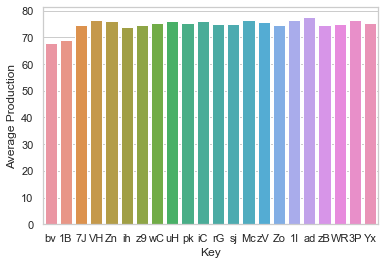

In [57]:
#Having checked 1BY6WEcLGh8j5v7, we can see that this average works

sns.set_theme(style="whitegrid")
%matplotlib inline
ax = sns.barplot(x=averages['Key'], y=averages['Average Production'])


<AxesSubplot:xlabel='Key', ylabel='Average Production'>

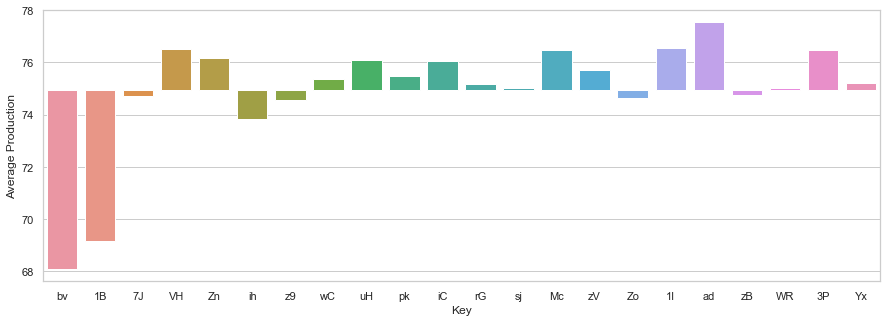

In [58]:
#This plot still makes it difficult to observe the differences between the different inverters

#It is easier to observe differences when we look at these barplots as deviations from the mean.

mean = averages['Average Production'].mean()
averages['Average Production'] -= mean

fig, (ax1) = plt.subplots(nrows=1, figsize=(15,5))
sns.barplot(x=averages['Key'], y=averages['Average Production'], data=averages,
            ax=ax1,
            bottom=mean)  

In [59]:
#############1.4###################

#From this plot, the negative outliers seem to be the inverters with keys bv and 1B. From looking at the raw data, and given we are
#..looking at the average 15min production values, an average production deviation from the average, of several factors in magnitude less the others
#... would seem to indicate that these do appear to be outliers. 

#In reality though, we may want to scale this to the scale of the full average production in order to be confident that these outliers
#are of a great enough order to be considered so. We can do this by taking the deviation from the average, as above, and taking it as a fraction or percentage
#of the average itself. For example, the bv is around 6 less than the average of around 74, i.e., 6/74*100 = 8%. Which as to whether you consider it an outlier 
#depends on the unseen factors of influence such as the location of inverters etc. 



In [60]:
#############1.5###################

#To find the daily production for each inverter, we must sum our Production values and then divide by the number of days for each inverter

repped3


,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,PLANT_ID,REP_MARKER,Production2
0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:00,4135001,1,0.0
1,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:15,4135001,1,0.0
2,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:30,4135001,1,0.0
3,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 00:45,4135001,1,0.0
4,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,15/05/2020 01:00,4135001,1,0.0
...,...,...,...,...,...,...,...,...,...
68773,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 22:45,4135001,1,0.0
68774,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:00,4135001,1,0.0
68775,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:15,4135001,1,0.0
68776,zVJPv84UY57bAof,0.0,0.0,5910.0,7363272.0,17/06/2020 23:30,4135001,1,0.0


In [61]:

medians = df_val_counts.drop(['Percentage Missing (%)', 'Quantity Missing'], 1)
codes = ['bv', '1B', '7J', 'VH', 'Zn', 'ih', 'z9', 'wC', 'uH', 'pk', 'iC', 'rG', 'sj', 'Mc', 'zV', 'Zo', '1I', 'ad', 'zB', 'WR', '3P', 'Yx' ]
medians['Key'] = codes
medians
#need to divide the sum of production values by some factor equal to the number of days per inverter
#We have 71808/22=3264 rows per inverter /(24*4) = 34 days, which is consistent with the 34 recorded days between May 15th 
#and  June 17th 
medians['Daily Production'] = repped3['Production2'].groupby(repped3['SOURCE_KEY']).sum()/34


C:\Users\Alex\AppData\Local\Temp/ipykernel_5092/2826917592.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  medians = df_val_counts.drop(['Percentage Missing (%)', 'Quantity Missing'], 1)


In [62]:
medians

,SOURCE_KEY,Key,Daily Production
bvBOhCH3iADSZry,3155,bv,6535.470588
1BY6WEcLGh8j5v7,3154,1B,6640.000000
7JYdWkrLSPkdwr4,3133,7J,7172.382353
VHMLBKoKgIrUVDU,3133,VH,7347.058824
ZnxXDlPa8U1GXgE,3130,Zn,7310.735294
ih0vzX44oOqAx2f,3130,ih,7086.617647
z9Y9gH1T5YWrNuG,3126,z9,7157.000000
wCURE6d3bPkepu2,3126,wC,7235.382353
uHbuxQJl8lW7ozc,3125,uH,7303.558824
pkci93gMrogZuBj,3125,pk,7244.941176


In [63]:
medians['Daily Production'].median()

7227.632352941177

In [64]:
##########################1.6###########################
#Q: Using this median production do you think is possible to identify underperformance?
#Q: Which inverter do you think is not performing according to the expectations?

#We again have that the bv and 1B inverters are creating less daily production than the other inverters, which implies
#... that they are 'underperforming'. However, 's to whether they are 'underperforming'  depends the organisations definition.
#If it simply refers to production, then clearly it is not performing. However, if it refers to some internal issue with the inverter panel array,
# and not, say, something which can be changed easily, like position within the solar field, or if it refers to the reciprocal, 
#then we cannot state as to whether it is performing without ascertaining the cause. 




In [65]:
########################1.7##############################

In [78]:
#As per the premise of this exercise, we now try to determine whether the irradiation data has a relationship that we can 
#quantify with the production, obtained solely from the field total_yield (which we have in turn used to find the production)
#, and not in relation to the other fields, such as AC and DC power. 

#Whether or not we can compare the production with the irradiation depends on the correlation between the two. If the two values 
#...are correlated then we can likely create some sort of predictive model between the two. 

#It is however, important to note that there will be little or no correlation between the 'TOTAL_YIELD' which is a cumilative quantity,
#....and the irradiation, which is an immiediate quantity. Instead, the area to look for correlation would be in the rate of change of total yield, 
#i.e., the derivative, or equivalently, the production, determined as above (total_yield(x) - total_yield(x-1))

#If a correlation was found between these quantities, then a model can likely be created. Given that we are working with a time series, 
#one potential model we could create would be a simple linear regression between the production values and the corresponding irradiation
#values equated by equivalent times. This could give a general feel for the inverters response to the irradiation. However, given the inverters
#are ultimately used to determine the effectiveness of the attached panels, which most likely would not respond linearly to additional radiation
#...given for example, material properties of the panels or electrical components involved. It could therefore be more predictive to seperate
#... the inverters and perform a non-linear regression such as Polynomial, of an order which seemed to best to fit the data.



In [79]:
##############################################################################################

In [80]:
###################################          TASK 2           ############################################

In [81]:
##############################################################################################

In [ ]:
#I shall go through in order of exercise what I would do to automate the report process now. 

#Assumption: the only input we receive is the two datasets in the form they are in currently

#Libraries required: 
#1.1-1.3 Pandas, Numpy
#1.4 - Tensorflow, Sci-kit Learn

#####1.1######
#To automate the process of calculating the percentage of missing data in the dataframe, the current method used in 1.1 would
#...work for the most part.. however, we would have to automatically determine the percentage factor, i.e., 
#in "df_val_counts['Percentage Missing (%)'] = 100-((df_val_counts['SOURCE_KEY'] /3264)*100)", the factor of 3264, i.e., the actual length 
#of rows in the full time-series evolution which can be calculated by just taking the len() of the df produced using the following
#"date_range = pd.date_range('2020-05-15 00:00', '2020-06-17 23:45', freq='15Min')
#df8 = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
#df8.index = date_range "

#####1.2######
#This process as described specifically may not be possible, I have just described what my first attempt would be really..
#However, inserting rows somehow based on where the time-skips occur should be possible with some trial and error. 

#In order to create an automated process of filling in the missing columns, I would perform a duplication process similar to what I
#attempted in this program, before switching to the process that I ultimately used, i.e., adding in markers manually which indicate the 
#rows which need to be and the number of times they need to be duplicated. To do this I would create a function to alter the
#formatting of the DATE_TIME column in the generation dataset into the standard format of XXXX-XX-XX XX:XX. I would then create 
#a function which would take as inputs the start data and end date of the datset in question, and output a seperate dataframe which 
#creates a time series where no instances are missed, like the 'df8' dataframe that I created earlier in the program. 


#I would then, by generally speaking, iterating through rows, comparing the data_time columns in both dataframes, and for 
#a particular inverter, where the date_time of the generation dataframe does not match that of the dummy times series, I would
# insert a new row into the generation dataframe, above the row in question, with the date_time value equalling that of the
#dummy time-series and the total_yield would be equivelent to the row above in the generation dataframe, in the same column.
#Then, even though this is not the main purpose, the AC/DC values could just be set to zero. Then the next row would be checked
#as such, and would of course, not be altered unless the equivalent rows in both dataframes disagreed. 

#####1.3######
#This would work pretty much the same as I have worked through in Task 1. After the rows had been inserted, the production could
#be found by taking the difference, then for a particular inverter, the mean could be found, which could then be stored in some
#dataframe which itself has been created in an automated way based on using the values in the source_key column as identifiers
#A function could then be used to create a plot like the plot/s created in Task 1. 

#####1.4#######
#Despite it being easier to identify outliers using a function acting on the raw data, that compares the production-lacking inverters
#in a normalised way as described in Task 1.4, there would likely be some deep-learning methods, contained in libraries such as tensorflow
#..that would allow for the graph itself to be analysed for outliers.

#####1.5######
#The process if finding the daily production, and then finding the median would work in an equivelent way as in Task 1.5

#####1.6######
#The degree to which the inverter daily production value is under the median value created could then be compared to 
#some threshold value at which the inverters are considered to be 'underperforming' in relation to the other inverters.

#####1.7######
#Using purely polynomial regression could be ineffective in producing regressions in automated ways, for this, it may be better
#to perform the regression using more advanced regressional machine learning models existing in libraries such as Tensorflow or
#Sci-kit learn.